# 8-8. 프로젝트: 인물 모드 문제점 찾기

## Step 1. 인물모드 직접 해 보기
<hr>

* 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
* 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
* 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

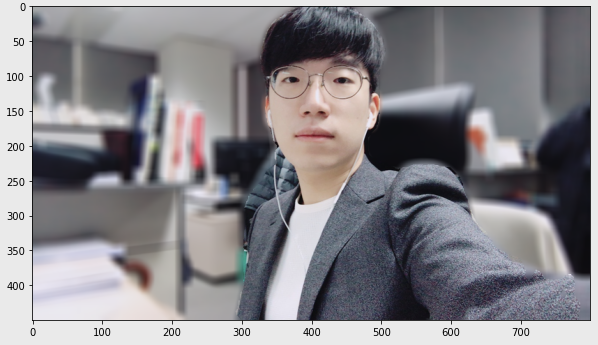

### 1) 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
<hr>

#### 디렉토리 구조
```
- aiffel/human_segmentation
    ├── models
        └── deeplab_model.tar.gz (미리 준비할 필요는 없습니다.)
    ├── images
        └── my_image.png   (사진 이름은 각자 파일명에 따라 다르게 사용하시면 됩니다)
```        

#### 경로 설정
```
mkdir -p ~/aiffel/human_segmentation/models
mkdir -p ~/aiffel/human_segmentation/images
```

In [1]:
# 기본 라이브러리 로드

import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# 이미지 3장 읽기

import os
my_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  # 내이미지
img1_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sjg.png'  # 송중기
img2_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/ksr.jpg'  # 강소라
img3_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/pbg.jpg'  # 박보검

my_img_orig = cv2.imread(my_img_path) 
img1_orig = cv2.imread(img1_path) 
img2_orig = cv2.imread(img2_path) 
img3_orig = cv2.imread(img3_path) 

print (my_img_orig.shape)
print (img1_orig.shape)
print (img2_orig.shape)
print (img3_orig.shape)

(2208, 2944, 3)
(423, 620, 3)
(464, 640, 3)
(423, 600, 3)


In [3]:
# DeepLabModel 선언
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# DeepLabModel 모델 다운로드 및 가중치 전처리 설정
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
# 이미지 사이즈 조정
my_img_resized, my_seg_map = MODEL.run(my_img_orig) # 내이미지
print (my_img_orig.shape, my_img_resized.shape, my_seg_map.max())

img1_resized, img1_seg_map = MODEL.run(img1_orig) # 연예인 1
print (img1_orig.shape, img1_resized.shape, img1_seg_map.max())

img2_resized, img2_seg_map = MODEL.run(img2_orig) # 연예인 2
print (img2_orig.shape, img2_resized.shape, img2_seg_map.max())

img3_resized, img3_seg_map = MODEL.run(img3_orig) # 연예인 3
print (img3_orig.shape, img3_resized.shape, img3_seg_map.max())

(2208, 2944, 3) (384, 513, 3) 20
(423, 620, 3) (349, 513, 3) 15
(464, 640, 3) (371, 513, 3) 15
(423, 600, 3) (361, 513, 3) 15


In [6]:
# 라벨 구분 설정
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [7]:
# 마스크 생성 및 시각화 함수 정의
def getMaskImg(img_show, seg_map):
    seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    
    return img_show

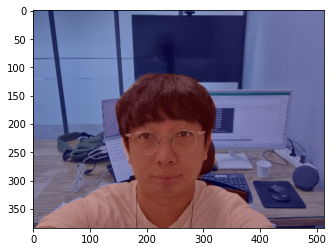

In [8]:
# 내이미지 세크멘테이션 생성
my_img_show = my_img_resized.copy()
my_img_show = getMaskImg(my_img_show, my_seg_map)
plt.imshow(cv2.cvtColor(my_img_show, cv2.COLOR_BGR2RGB))
plt.show()

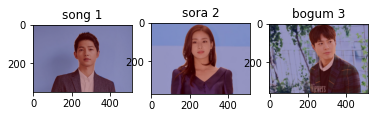

In [9]:
# 연예인1,2,3 세크멘테이션 생성
img1_show = img1_resized.copy()
img1_show = getMaskImg(img1_show, img1_seg_map)
img2_show = img2_resized.copy()
img2_show = getMaskImg(img2_show, img2_seg_map)
img3_show = img3_resized.copy()
img3_show = getMaskImg(img3_show, img3_seg_map)

ax = plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img1_show, cv2.COLOR_BGR2RGB))
ax.set_title('song 1')

ax = plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img2_show, cv2.COLOR_BGR2RGB))
ax.set_title('sora 2')

ax = plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img3_show, cv2.COLOR_BGR2RGB))
ax.set_title('bogum 3')

plt.show()

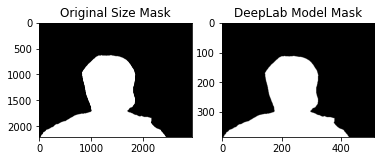

In [10]:
# 내이미지에 대해서 세그멘테이션 결과를 원래 크기로 복원
my_seg_map = np.where(my_seg_map == 15, 15, 0)
my_img_mask = my_seg_map * (255/my_seg_map.max())
my_img_mask = my_img_mask.astype(np.uint8)

my_img_mask_up = cv2.resize(my_img_mask, my_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, my_img_mask_up = cv2.threshold(my_img_mask_up, 128, 255, cv2.THRESH_BINARY)
ax = plt.subplot(1,2,1)
plt.imshow(my_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(my_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

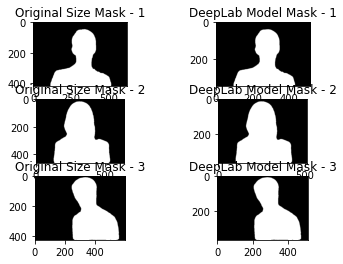

In [11]:
# 연예인 이미지에 대해서 세그멘테이션 결과를 원래 크기로 복원
img1_seg_map = np.where(img1_seg_map == 15, 15, 0)
img1_mask = img1_seg_map * (255/img1_seg_map.max())
img1_mask = img1_mask.astype(np.uint8)
    
img2_seg_map = np.where(img2_seg_map == 15, 15, 0)
img2_mask = img2_seg_map * (255/img2_seg_map.max())
img2_mask = img2_mask.astype(np.uint8)

img3_seg_map = np.where(img3_seg_map == 15, 15, 0)
img3_mask = img3_seg_map * (255/img3_seg_map.max())
img3_mask = img3_mask.astype(np.uint8)

img1_mask_up = cv2.resize(img1_mask, img1_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img1_mask_up = cv2.threshold(img1_mask_up, 128, 255, cv2.THRESH_BINARY)

img2_mask_up = cv2.resize(img2_mask, img2_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img2_mask_up = cv2.threshold(img2_mask_up, 128, 255, cv2.THRESH_BINARY)

img2_mask_up = cv2.resize(img2_mask, img2_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img2_mask_up = cv2.threshold(img2_mask_up, 128, 255, cv2.THRESH_BINARY)

img3_mask_up = cv2.resize(img3_mask, img3_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img3_mask_up = cv2.threshold(img3_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(3,2,1)
plt.imshow(img1_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask - 1')

ax = plt.subplot(3,2,2)
plt.imshow(img1_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask - 1')

ax = plt.subplot(3,2,3)
plt.imshow(img2_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask - 2')

ax = plt.subplot(3,2,4)
plt.imshow(img2_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask - 2')

ax = plt.subplot(3,2,5)
plt.imshow(img3_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask - 3')

ax = plt.subplot(3,2,6)
plt.imshow(img3_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask - 3')

plt.show()

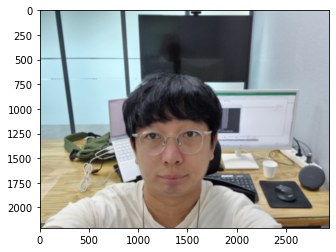

In [12]:
# 내 이미지 배경 흐리게 처리
my_img_orig_blur = cv2.blur(my_img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(my_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

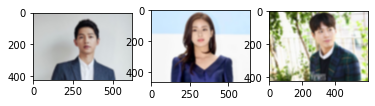

In [13]:
# 연예인 배경 흐리게 처리

ax = plt.subplot(1,3,1)
img1_orig_blur = cv2.blur(img1_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img1_orig_blur, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,3,2)
img2_orig_blur = cv2.blur(img2_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img2_orig_blur, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,3,3)
img3_orig_blur = cv2.blur(img3_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img3_orig_blur, cv2.COLOR_BGR2RGB))

plt.show()

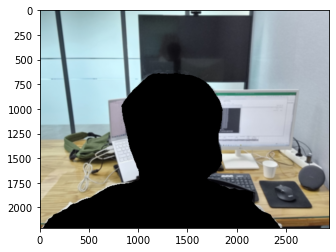

In [14]:
# 내 이미지 배경 추출
my_img_mask_color = cv2.cvtColor(my_img_mask_up, cv2.COLOR_GRAY2BGR)
my_img_bg_mask = cv2.bitwise_not(my_img_mask_color)
my_img_bg_blur = cv2.bitwise_and(my_img_orig_blur, my_img_bg_mask)
plt.imshow(cv2.cvtColor(my_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

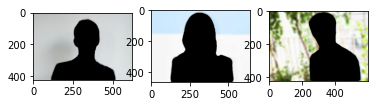

In [15]:
# 연예인 이미지 배경 추출
img1_mask_color = cv2.cvtColor(img1_mask_up, cv2.COLOR_GRAY2BGR)
img1_bg_mask = cv2.bitwise_not(img1_mask_color)
img1_bg_blur = cv2.bitwise_and(img1_orig_blur, img1_bg_mask)

img2_mask_color = cv2.cvtColor(img2_mask_up, cv2.COLOR_GRAY2BGR)
img2_bg_mask = cv2.bitwise_not(img2_mask_color)
img2_bg_blur = cv2.bitwise_and(img2_orig_blur, img2_bg_mask)

img3_mask_color = cv2.cvtColor(img3_mask_up, cv2.COLOR_GRAY2BGR)
img3_bg_mask = cv2.bitwise_not(img3_mask_color)
img3_bg_blur = cv2.bitwise_and(img3_orig_blur, img3_bg_mask)

ax = plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img1_bg_blur, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img2_bg_blur, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img3_bg_blur, cv2.COLOR_BGR2RGB))

plt.show()

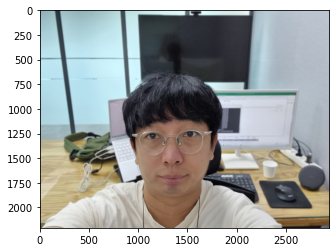

In [16]:
# 내 이미지 배경 영상과 사람 영상을 합성
my_img_concat = np.where(my_img_mask_color==255, my_img_orig, my_img_bg_blur)
plt.imshow(cv2.cvtColor(my_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

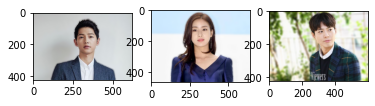

In [17]:
# 연예인 영상과 사람 영상을 합성
img1_concat = np.where(img1_mask_color==255, img1_orig, img1_bg_blur)
img2_concat = np.where(img2_mask_color==255, img2_orig, img2_bg_blur)
img3_concat = np.where(img3_mask_color==255, img3_orig, img3_bg_blur)

ax = plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img1_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img2_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img3_concat, cv2.COLOR_BGR2RGB))

plt.show()

### 2) 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.

In [18]:
# 1. 고양이 이미지 읽기
import os
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  # 내이미지
cat_img_orig = cv2.imread(cat_img_path) 

print (cat_img_orig.shape)

(1717, 966, 3)


In [19]:
# 2. 이미지 사이즈 조정
cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig) # 내이미지
print (cat_img_orig.shape, cat_img_resized.shape, cat_seg_map.max())

(1717, 966, 3) (513, 288, 3) 8


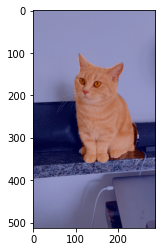

In [20]:
# 3. 고양이 이미지 세크멘테이션 생성
cat_img_show = cat_img_resized.copy()

# 라벨 구분 설정 (고양이: 8, 사람: 15)
cat_seg_map = np.where(cat_seg_map == 8, 8, 0) # 예측 중 고양이[8]만 추출
cat_img_mask = cat_seg_map * (255/cat_seg_map.max())
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)
plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()


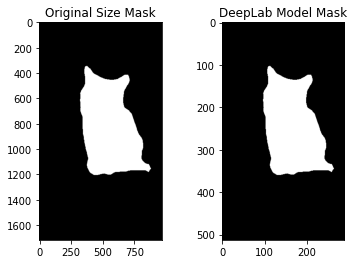

In [21]:
# 4. 고양이 이미지에 대해서 세그멘테이션 결과를 원래 크기로 복원
cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

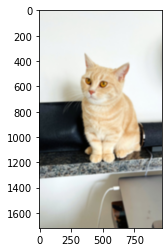

In [22]:
# 5. 고양이 이미지 배경 흐리게 처리
cat_img_orig_blur = cv2.blur(cat_img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

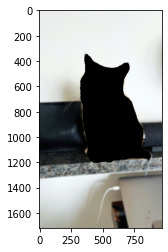

In [23]:
# 6. 고양이 이미지 배경 추출
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

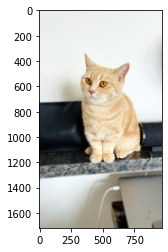

In [24]:
# 7. 고양이 이미지 배경 영상과 사람 영상을 합성
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 3) 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

(640, 966, 3)


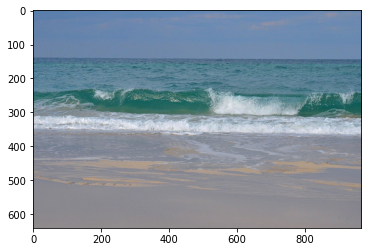

(2208, 2944, 3)


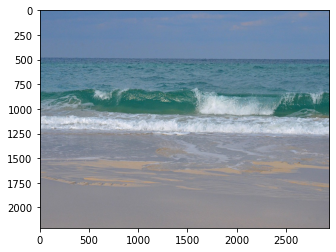

In [25]:
# 바다 이미지 읽기
sea_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sea.jpg'  # 바다이미지
sea_img_orig = cv2.imread(sea_img_path) 
print (sea_img_orig.shape)
plt.imshow(cv2.cvtColor(sea_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 얼굴 이미지와 사이즈를 동일하게 적용( 2944 x 2208 )
sea_img_orig = cv2.resize(sea_img_orig,(2944, 2208),interpolation=cv2.INTER_CUBIC)
print (sea_img_orig.shape)
plt.imshow(cv2.cvtColor(sea_img_orig, cv2.COLOR_BGR2RGB))
plt.show()


In [26]:
sea_img_resized, sea_img_seg_map = MODEL.run(sea_img_orig)
print (sea_img_orig.shape, sea_img_resized.shape, sea_img_seg_map.max())

(2208, 2944, 3) (384, 513, 3) 0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


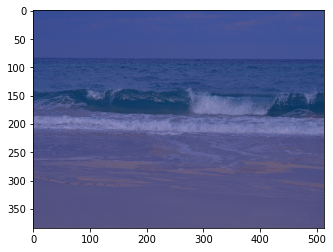

In [27]:
# 바다 이미지 세크멘테이션 생성
sea_img_show = sea_img_resized.copy()
sea_img_show = getMaskImg(sea_img_show, sea_img_seg_map)
plt.imshow(cv2.cvtColor(sea_img_show, cv2.COLOR_BGR2RGB))
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


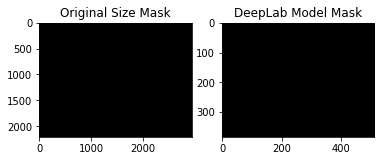

In [28]:
# 바다 이미지에 대해서 세그멘테이션 결과를 원래 크기로 복원
sea_img_seg_map = np.where(sea_img_seg_map == 15, 15, 0)
sea_img_mask = sea_img_seg_map * (255/sea_img_seg_map.max())
sea_img_mask = sea_img_mask.astype(np.uint8)

sea_img_mask_up = cv2.resize(sea_img_mask, sea_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, sea_img_mask_up = cv2.threshold(sea_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(sea_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(sea_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()


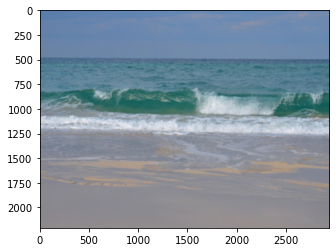

In [29]:
# 바다 이미지 배경 추출
# 내 이미지 배경 흐리게 처리
sea_img_orig_blur = cv2.blur(sea_img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(sea_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()


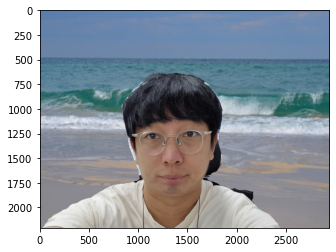

In [31]:
# 바다 배경과 내 이미지 합성
my_sea_img_concat = np.where(my_img_mask_color==255, my_img_orig, sea_img_orig_blur)
plt.imshow(cv2.cvtColor(my_sea_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. 사진에서 문제점 찾기
<hr>

그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

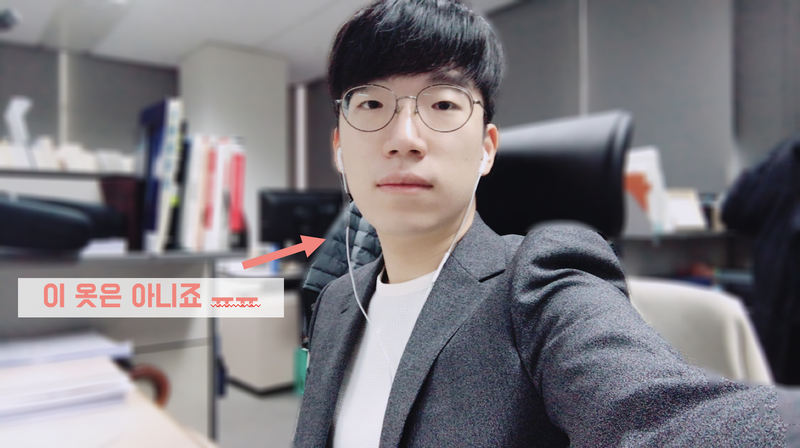

#### 세그멘테이션의 한계
Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

#### 피사계 심도 이해하기
우선 피사계심도의 개념부터 명확히 이해해 봅시다.

#### 아웃포커싱 방법 및 원리
* [3D Depth Camera 활용하기](https://ggyul.tistory.com/12)

카메라 2개를 통해 생성한 3d 영상으로 인물모드를 더 정확하게 만들 수 있을까요? 우리는 카메라 1대가 찍은 영상에서 semantic segmentation을 시도하였고, 그 결과가 정확하지 않았습니다. 요즘 스마트폰의 카메라는 렌즈가 2개 달려있지요? 왜 굳이 그렇게까지 하는지 아래 링크를 보면서 이해해 봅시다.

#### 3D 깊이 카메라 기술
* [깊이 영상(Depth image) 활용하기](https://m.blog.naver.com/panoptics/221336152952)

하지만 꼭 카메라가 2개여야 할까요? 아래 이미지는 Struct2Depth 라는 기법을 소개한 Google Brain의 논문에 있는 이미지입니다. 아래 이미지의 세 번째 컬럼이 보다 명확하게 depth에 따른 물체인식을 보여 주는데, 이것은 LiDAR가 없이도 아주 정확한 segmentation을 동반한 depth sensor가 가능함을 보여줍니다.

* [Recognizing Depth in Autonomous Driving](https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6)
* [Unsupervised Learning of Depth and Ego-Motion: A Structured Approach](https://sites.google.com/view/struct2depth)
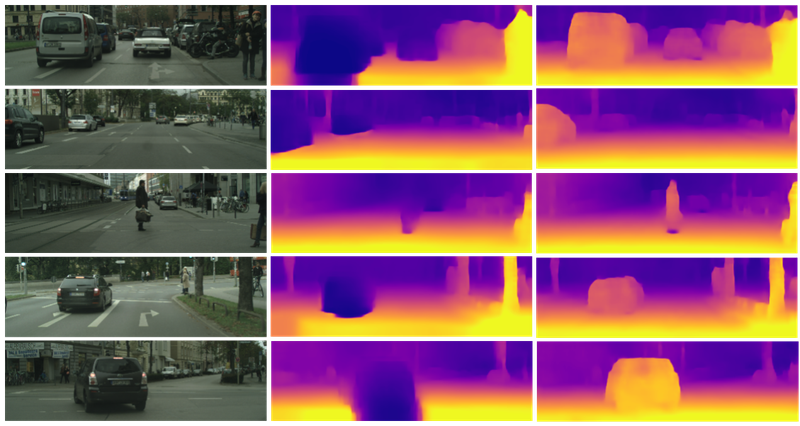


#### IR(적외선)을 활용한 사례
구글 pixel4에 IR 카메라가 달려있는데, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.

* [uDepth: Real-time 3D Depth Sensing on the Pixel 4](https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html)


엔지니어로서 본인이 선택한 솔루션을 잘 설명해 주세요. 가능하다면 순서도(Flow Chart)를 활용하면 좋습니다. 멋진 아이디어를 기대하겠습니다!!



**루브릭**

아래의 기준을 바탕으로 프로젝트를 평가합니다.


| 평가문항 | 상세기준 |
|:---|:---|
| 1. 인물모드 사진을 성공적으로 제작하였다. | 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, <br>배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다. |
| 2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다. | 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다. |
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다. | 추가적인 depth 정보를 활용하여 semantic segmentation mask의<br> 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다. |


프로젝트 업로드 (URL)

GitHub URL을 입력하신 후 하단의 [성취하기] 버튼을 눌러주세요.

## 회고

### 1. 이번 프로젝트에서 어려웠던 점

> * 단어들이 생소했음 : 피사계 심도??
> * 얼굴 이미지 경계에서 의자부분을 잘라내는 것이 어려웠음( 감도 안 옴 )

### 2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

> * 알아낸 점 : 코딩 몇 줄로, 특정이미지에서 사람, 고양이 등을 쉽게 찾아낼 수 있다는 것

> * 모호한 점 : 크로마키로 붙이는게 저렇게 붙이는게 맞는지..?


### 3. 루브릭 평가 지표를 맞추기 위해 시도한 것들.

> * 1. 인물 모드 사진에 대해서만 이라도 하고자 했음 ( 2,3번은 생각이 나지 않음.. )



### 4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정.

> 문제점은 알겠으나, 어떻게 해결해야 하는지를 관련글을 읽어봐도 잘 모르겠음


### 5. 자기 다짐

> python으로 사진/이미지 다루는 것에 대해서 관심을 가져야겠다고 생각함